In [1]:
# LIST OF UPDATES
#
# Added bias (constant) to each linear layer
# Switched to using equivalent keras optimizer - SGD 
# Moved loss calculation to an independent function
# Switched to defining the network as Keras layers(!)
# Add tf.function to training loop - 10x speed increase(!)
# Switch to calculating gradients with keras 'trainable_weight' vs tf 'variables' 
# Tried using Keras Model.fit but order of magnitude slower than custom loop!
# Switch to train/val/test -> Showed that validation accuracy peaks at about 55% Training accuracy :(
# Switch to MeanSquaredError as loss function (But this is not a good error for classification)
# Add callback support to custom training loop
# Early completion based on validation changes
# Switch to correct method of regularisation with L2 Loss
# Addition of Dropout for regularisation
# Batch support (improves regularisation)
# Tried various train/test/val combinations - results are very sensitive to this.
# Tried various activation functions - "elu" seems best (not sure why yet)
# Switched to BinaryCrossEntropy loss function from keras
# Switched to Adam optimiser with scheduled learning
# Utilised log x-scale to compare model plot results
# Switch to "relu" activation function on hidden nodes - good for variables in 0 to 1 range.
# Add Accuracy as a metric
# Add multiple plots to compare metrics
# Switch to Hinge loss function- better for penalising wrong sign!
# Switch to tanh activation function and -1/1 labels (for Hinge)
# Initialise variables with "he-uniform" - better for relu?
# Regularisation after the activiation function, using Lamda to control how much impact.
# TODO : Represent data using windowing method


In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import numpy as np
import pandas as pd

import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils
from marketinsights.api.model import MarketInsightsModel
from marketinsights.remote.ml import MIAssembly

from tqdm import tqdm, trange
from functools import partialmethod

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt


tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

2023-05-14 16:04:01.404274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 16:04:01.881231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-14 16:04:01.881265: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-14 16:04:04.011174: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
#DATASET_ID1 = "dbaab93d94795145539e595fab79f2d4"  # DOW
#DATASET_ID1 = "4234f0f1b6fcc17f6458696a6cdf5101"  # DOW
DATASET_ID1 = "09dcbc101dd03d999a479baa924901b3" # 2023 - Corrected 
NUM_FEATURES = (2 * 4) + 1

assembly = MIAssembly(secret="marketinsights-k8s-cred")

# Dataset
dataset, descriptor = assembly.get_dataset_by_id(DATASET_ID1, debug=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2013-01-02 15:00:00-05:00 to 2018-08-01 15:00:00-04:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1387 non-null   float64
 1   1       1387 non-null   float64
 2   2       1387 non-null   float64
 3   3       1387 non-null   float64
 4   4       1387 non-null   float64
 5   5       1387 non-null   float64
 6   6       1387 non-null   float64
 7   7       1387 non-null   float64
 8   8       1387 non-null   float64
 9   9       1387 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 119.2 KB


In [3]:
# Flip labels for Hinge loss function
labels = dataset[9]
labels[labels == 0] = -1
dataset[9] = labels
dataset

/tmp/ipykernel_20724/1195080844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[labels == 0] = -1


,0,1,2,3,4,5,6,7,8,9
Date_Time,,,,,,,,,,
2013-01-02 15:00:00-05:00,0.390854,0.826284,0.199852,0.508756,0.504133,1.000000,0.000000,0.629408,0.051259,1
2013-01-03 15:00:00-05:00,0.766445,1.000000,0.586159,0.943148,0.943148,0.944016,0.000000,0.487062,0.108321,-1
2013-01-04 15:00:00-05:00,0.096991,1.000000,0.000000,0.631825,0.632902,0.905283,0.340489,0.847693,0.043706,1
2013-01-07 15:00:00-05:00,0.078908,0.468290,0.000000,0.337985,0.337655,1.000000,0.253843,0.984516,0.071635,1
2013-01-08 15:00:00-05:00,0.000000,0.748026,0.000000,0.685708,0.685012,1.000000,0.344723,0.518904,0.068146,1
...,...,...,...,...,...,...,...,...,...,...
2018-07-26 15:00:00-04:00,0.117785,0.779641,0.000000,0.500333,0.492980,1.000000,0.345889,0.654713,0.078719,-1
2018-07-27 15:00:00-04:00,0.378094,0.888481,0.000000,0.861922,0.845986,1.000000,0.287613,0.489824,0.109395,1
2018-07-30 15:00:00-04:00,0.307187,0.954621,0.000000,0.892212,0.903560,1.000000,0.369722,0.483388,0.102674,-1


In [4]:
dataset = tf.cast(dataset, tf.float32)

# Split into Train/Val/Test
n = len(dataset)
train_df = dataset[:1200]
val_df = dataset[1200:1300]
test_df = dataset[1300:]

# Split into features/labels
train_x, train_y = train_df[:, :NUM_FEATURES], train_df[:,NUM_FEATURES:]
val_x, val_y =  val_df[:, :NUM_FEATURES], val_df[:,NUM_FEATURES:]
test_x, test_y =  test_df[:, :NUM_FEATURES], test_df[:,NUM_FEATURES:]

2023-05-14 16:04:11.426423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 16:04:11.427641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-14 16:04:11.427724: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-14 16:04:11.427798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-14 16:04:11.427869: W tensorflow/c

In [71]:

def batches(x, y, batch_size):
    return [(batch, x[batch*batch_size:(batch+1)*batch_size], y[batch*batch_size:(batch+1)*batch_size]) for batch in range(int(len(x) / batch_size))]


def roundTan(x):
    x = tf.nn.tanh(mlmodel(x))
    x = tf.where(x < 0, -1., x)
    x = tf.where(x > 0, 1., x)
    return x

def train(mlmodel, epochs=100000, _callbacks=[]):
    
    callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=True, model=mlmodel)
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      0.001,
      decay_steps=1000,
      decay_rate=1,
      staircase=False)

    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SquaredHinge()
    val_loss_fn = tf.keras.metrics.SquaredHinge()
    metric = tf.keras.losses.MeanSquaredError()
    accuracyMetric = tf.keras.metrics.Accuracy()
    val_accuracyMetric = tf.keras.metrics.Accuracy()
    lamda = tf.constant(0.5, tf.float32)
    
    @tf.function  # Make it fast.
    def train_on_batch(x, y):
        with tf.GradientTape() as tape:
                        
            loss = loss_fn(y_pred=tf.nn.tanh(mlmodel(x, training=True)), y_true=y) 
            regularization_loss=tf.add_n(mlmodel.losses)
            loss = loss + regularization_loss * lamda
            
            #binary_cross_entropy = metric(y_pred=y_pred, y_true=y) 
            
            #val_binary_cross_entropy = metric(y_pred=val_y_pred, y_true=val_y)
            val_loss = val_loss_fn(y_pred=tf.nn.tanh(mlmodel(val_x)), y_true=val_y) 
            
            accuracy = accuracyMetric(y_pred=roundTan(x), y_true=y)
            val_accuracy = val_accuracyMetric(y_pred=roundTan(val_x), y_true=val_y)
            
            gradients = tape.gradient(loss, mlmodel.trainable_weights)
        optimizer.apply_gradients(zip(gradients, mlmodel.trainable_weights))
        return {
            "loss":loss, 
            "val_loss": val_loss, 
            #"metric":binary_cross_entropy, 
            #"val_metric":val_binary_cross_entropy, 
            "accuracy": accuracy,
            "val_accuracy": val_accuracy,
            "regularization_loss":regularization_loss}


    logs = {}
    mlmodel.stop_training = False

    
    callbacks.on_train_begin(logs=logs)

    # Format training loop
    for epoch in range(epochs):

        callbacks.on_epoch_begin(epoch, logs=logs)
        #mlmodel.reset_states() # Not needed?

        for batch, batch_x, batch_y in batches(train_x, train_y, 400):

            callbacks.on_batch_begin(batch, logs=logs)
            callbacks.on_train_batch_begin(batch, logs=logs)

            logs = train_on_batch(batch_x, batch_y)

            callbacks.on_train_batch_end(batch, logs=logs)
            callbacks.on_batch_end(batch, logs=logs)

        callbacks.on_epoch_end(epoch, logs=logs)

        if epoch % 1000 == 0:
            accuracy = tf.keras.metrics.Accuracy()(roundTan(train_x), train_y)
            val_accuracy = tf.keras.metrics.Accuracy()(roundTan(val_x), val_y)
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}, Accuracy: {logs["accuracy"]}, Val Accuracy: {logs["val_accuracy"]}')

        if mlmodel.stop_training:
            print(f'Step {epoch} - Training Loss: {logs["loss"]}, Val Loss: {logs["val_loss"]}')
            break

    callbacks.on_train_end(logs=logs)

    # Fetch the history object we normally get from keras.fit
    history_object = None
    for cb in callbacks:
        if isinstance(cb, tf.keras.callbacks.History):
            history_object = cb
    assert history_object is not None
    
    return history_object

In [72]:
TOTAL_EPOCHS = 100000

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, start_from_epoch=500, patience=10000, restore_best_weights=True)
# Set up callbacks
callbacks = [earlyStopping]


In [39]:
histories = {}

In [40]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

histories["64x4"] = train(mlmodel, TOTAL_EPOCHS, callbacks)

Step 0 - Training Loss: 1.2461752891540527, Val Loss: 1.4155644178390503, Accuracy: 0.47749999165534973, Val Accuracy: 0.503333330154419
Step 1000 - Training Loss: 0.18736392259597778, Val Loss: 1.1590567827224731, Accuracy: 0.852519154548645, Val Accuracy: 0.5891641974449158
Step 2000 - Training Loss: 0.06773331761360168, Val Loss: 1.2871589660644531, Accuracy: 0.9119994044303894, Val Accuracy: 0.5844277739524841
Step 3000 - Training Loss: 0.040374964475631714, Val Loss: 1.369448184967041, Accuracy: 0.9359180331230164, Val Accuracy: 0.5772731304168701
Step 4000 - Training Loss: 0.03405457362532616, Val Loss: 1.422849416732788, Accuracy: 0.9483043551445007, Val Accuracy: 0.5758185386657715
Step 5000 - Training Loss: 0.032333891838788986, Val Loss: 1.4570915699005127, Accuracy: 0.9551159739494324, Val Accuracy: 0.5762600898742676
Step 6000 - Training Loss: 0.03069372847676277, Val Loss: 1.486071228981018, Accuracy: 0.9609290361404419, Val Accuracy: 0.5758473873138428
Step 7000 - Trainin

In [73]:
NUM_LABELS = 1
HIDDEN_UNITS = 64

# Prepare our layer, loss, and optimizer.
mlmodel = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(HIDDEN_UNITS, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_LABELS),
    ]
)

histories["64x4+DO+Reg:Lam.5"] = train(mlmodel, TOTAL_EPOCHS, callbacks)

Step 0 - Training Loss: 1.1408758163452148, Val Loss: 1.0030075311660767, Accuracy: 0.48750001192092896, Val Accuracy: 0.5066666603088379
Step 1000 - Training Loss: 0.9903020262718201, Val Loss: 1.0093761682510376, Accuracy: 0.5557917356491089, Val Accuracy: 0.49126872420310974
Step 2000 - Training Loss: 0.9277854561805725, Val Loss: 1.0091289281845093, Accuracy: 0.5928127765655518, Val Accuracy: 0.5201898813247681
Step 3000 - Training Loss: 0.8811261057853699, Val Loss: 1.0114396810531616, Accuracy: 0.6145784854888916, Val Accuracy: 0.5323914289474487
Step 4000 - Training Loss: 0.8779301047325134, Val Loss: 1.016123652458191, Accuracy: 0.6279528141021729, Val Accuracy: 0.5360584855079651
Step 5000 - Training Loss: 0.9217687249183655, Val Loss: 1.0240639448165894, Accuracy: 0.6374148726463318, Val Accuracy: 0.5343004465103149
Step 6000 - Training Loss: 0.8970019817352295, Val Loss: 1.03168523311615, Accuracy: 0.6442365050315857, Val Accuracy: 0.5317574739456177
Step 7000 - Training Los

Text(0.5, 0, 'Epochs')

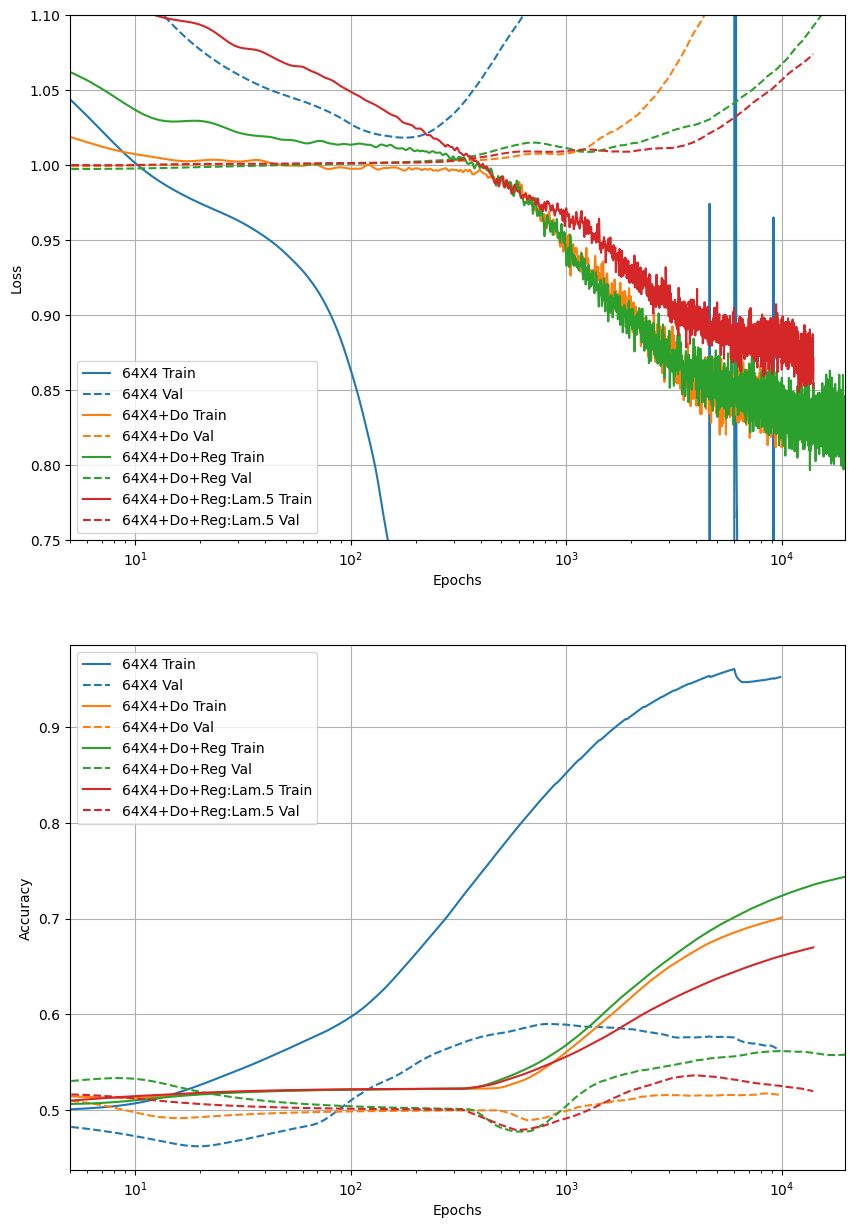

In [74]:
plt.rcParams['figure.figsize'] = [10, 15]

# PLOT histories
plt.subplot(211)
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10).plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.75, 1.1])
plt.xlabel("Epochs")

plt.subplot(212)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10).plot(histories)
#plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.5, 0.55])
plt.xlabel("Epochs")





In [194]:
histories["64x4"].validation_data

In [75]:
tf.keras.metrics.Accuracy()(roundTan(val_x), val_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.55>

In [76]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(train_x))).numpy()), ppl.onehot(train_y.numpy()), threshold=0.5)

Won : 800.0
Lost : 400.0
Total : 1200.0
Diff : 400.0
Edge : 33.333333333333336%
Information Coefficient : 0.3333333730697632


0.6666667

In [77]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(val_x))).numpy()), ppl.onehot(val_y.numpy()), threshold=0.5)

Won : 55.0
Lost : 45.0
Total : 100.0
Diff : 10.0
Edge : 10.0%
Information Coefficient : 0.10000002384185791


0.55

In [78]:
mlutils.evaluate(ppl.onehot(toSigmoid(tf.nn.tanh(mlmodel(test_x))).numpy()), ppl.onehot(test_y.numpy()), threshold=.50)

Won : 48.0
Lost : 39.0
Total : 87.0
Diff : 9.0
Edge : 10.344827586206897%
Information Coefficient : 0.10344827175140381


0.55172414

In [92]:
tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_pred=mlmodel(val_x), y_true=toSigmoid(val_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.69271004>

In [91]:
tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_pred=baseline, y_true=toSigmoid(val_y))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6941605066964598>

In [101]:
baseline = [np.sum(toSigmoid(train_y)==1)/len(train_y)]*len(test_y)

In [102]:
tf.keras.metrics.BinaryAccuracy()(y_pred=baseline, y_true=toSigmoid(test_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.43678162>

In [103]:
tf.keras.metrics.BinaryAccuracy()(y_pred=tf.nn.sigmoid(mlmodel(test_x)), y_true=toSigmoid(test_y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.55172414>

In [28]:
def toSigmoid(x):
    return tf.where(x<0, 0., 1.)

In [79]:
mlmodel.save("really_really_great_model")

INFO:tensorflow:Assets written to: really_really_great_model/assets


In [264]:
mymodel = tf.keras.models.load_model('great_model')

In [1]:
mlmodel

NameError: name 'mlmodel' is not defined